This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

## Modern convnet architecture patterns

### Modularity, hierarchy, and reuse

### Residual connections

## **Residual connections於一般卷積架構**

**Residual block where the number of filters changes**

當濾波器變化時的Residual block

In [32]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
residual = layers.Conv2D(64, 1)(residual)
x = layers.add([x, residual])

**Case where target block includes a max pooling layer**

含一個最大池化層的情況

In [33]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, padding="same")(x)
residual = layers.Conv2D(64, 1, strides=2)(residual)
x = layers.add([x, residual])

In [34]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(1./255)(inputs)

def residual_block(x, filters, pooling=False):
    residual = x
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual)
    x = layers.add([x, residual])
    return x

x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 32, 32, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 32, 32)   896         rescaling[0][0]                  
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 32, 32, 32)   9248        conv2d_6[0][0]                   
______________________________________________________________________________________________

進行Batch normalization可以平均特徵的分布情況，增加整個網路的泛化能力，避免在中間的訓練過程中一些數據的影響在中後層的地方不斷放大，進而增加整個model的不穩定性，甚至影響訓練速度及導致overfitting。

### Batch normalization

### Depthwise separable convolutions

### Putting it together: A mini Xception-like model

In [46]:
#from google.colab import files
#files.upload()

In [47]:
#!mkdir ~/.kaggle
#!cp kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json
#!kaggle competitions download -c dogs-vs-cats
#!unzip -qq train.zip

#### 直接複製CH8的檔案，不用另外分割檔案出來

In [48]:
import os
import shutil

old_path = 'E:\\deep-learning-with-python-notebooks-master\\HW\\CH8\\dogs-vs-cats'
new_path = os.getcwd() + '\\dogs-vs-cats'

if os.path.exists(new_path) == False:
    shutil.copytree(old_path, new_path)

In [49]:
import os, shutil, pathlib
from tensorflow.keras.utils import image_dataset_from_directory

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")


In [50]:
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

#make_subset("train", start_index=0, end_index=1000)
#make_subset("validation", start_index=1000, end_index=1500)
#make_subset("test", start_index=1500, end_index=2500)



#### 建立train、validation、test集

In [51]:
import os, shutil, pathlib
from tensorflow.keras.utils import image_dataset_from_directory

new_base_dir = pathlib.Path("dogs-vs-cats/cats_vs_dogs_small")

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


#### 使用翻轉、調整角度等方法增加圖片強度

In [52]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [53]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

#### 開始訓練

In [54]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
history = model.fit(
    train_dataset,
    epochs=100,
    batch_size=4,
    validation_data=validation_dataset)

Epoch 1/100
63/63 [==============================] - 27s 330ms/step - loss: 0.7014 - accuracy: 0.5640 - val_loss: 0.7001 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 20s 322ms/step - loss: 0.6584 - accuracy: 0.6225 - val_loss: 0.6957 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 20s 321ms/step - loss: 0.6366 - accuracy: 0.6410 - val_loss: 0.7069 - val_accuracy: 0.5000
Epoch 4/100
63/63 [==============================] - 20s 324ms/step - loss: 0.6164 - accuracy: 0.6590 - val_loss: 0.6957 - val_accuracy: 0.5040
Epoch 5/100
63/63 [==============================] - 20s 320ms/step - loss: 0.6071 - accuracy: 0.6730 - val_loss: 0.7240 - val_accuracy: 0.5000
Epoch 6/100
63/63 [==============================] - 20s 323ms/step - loss: 0.5816 - accuracy: 0.7065 - val_loss: 0.9078 - val_accuracy: 0.5000
Epoch 7/100
63/63 [==============================] - 20s 315ms/step - loss: 0.5756 - accuracy: 0.7135 - val_loss: 0.9815 - val_accuracy:

#### 分別顯示訓練過程中loss跟accuracy的值

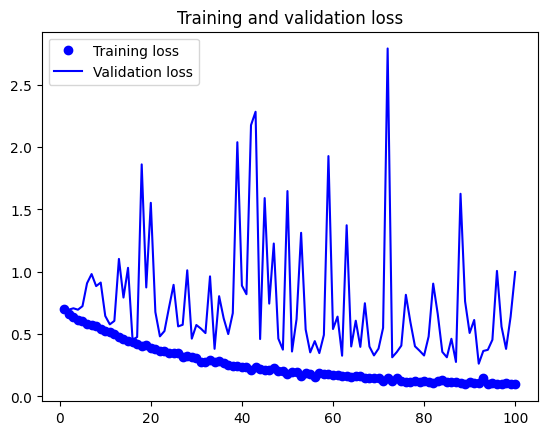

In [62]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

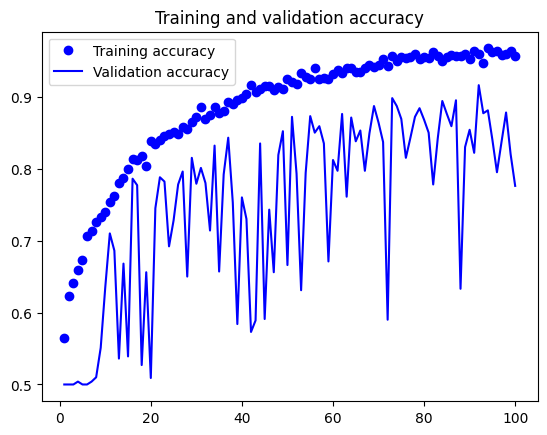

In [64]:
epochs = range(1, len(history.history["accuracy"]) + 1)
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
plt.figure()
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()